In [1]:
# !rm -r sample_data .config
# !git clone https://github.com/saveliybabin/VRP-solver .

In [2]:
import requests
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from train import train_epoch_sl
from nets.nar_model_vrp import NARModel
from nets.encoders.gnn_encoder import GNNEncoder
from utils import torch_load_cpu, load_problem
import warnings
warnings.filterwarnings('ignore')

In [3]:
# !pip install pickle5
import pickle5 as pickle

In [4]:
!pip install ortools

You should consider upgrading via the 'c:\users\sbabin\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


In [5]:
problem = load_problem('cvrp')

In [6]:
import pickle
with open('data/train_cvrp_v3_12800.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
with open('data/val_cvrp_v5_1000.pkl', 'rb') as f:
    val_dataset = pickle.load(f)    
    

In [7]:
# train_dataset = problem.make_dataset(
#         'data/vrp/dataset_test.pkl', size=21, num_samples=12800
#     )


In [8]:
# import pickle
# def save_object(obj, filename):
#     with open(filename, 'wb') as outp:  # Overwrites any existing file.
#         pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# # sample usage
# save_object(train_dataset, 'train_cvrp_v3_12800.pkl')

In [9]:
# val_dataset = problem.make_dataset(
#         'data/vrp/dataset_test_2.pkl', size=21, num_samples=1000
#     )

In [10]:
# save_object(val_dataset, 'val_cvrp_v5_1000.pkl')

In [11]:
train_example = train_dataset[1]
train_example['demand'].shape

torch.Size([20])

In [12]:
len(train_example['tour_nodes'])

26

In [13]:
def edges(adj):

    for i, neighbors in enumerate(adj):
        for j, v in enumerate(neighbors):
            if v:
                yield (i, j)

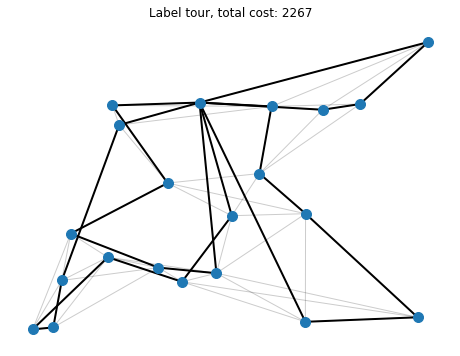

In [14]:
all_loc = np.concatenate((np.array(train_example['depot']).reshape(1, -1), np.array(train_example['loc'])), 0)
dist_matrix = squareform(pdist(all_loc))
G = nx.from_numpy_array(1-train_example['graph'].numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord for i, coord in enumerate(all_loc)}
# tour = train_example['tour_edges'].nonzero().numpy()
tour = [i for i in edges(train_example['adj'])]
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=tour, )
# tour = train_example['tour_nodes'].numpy()
# tour = np.append(tour, tour[0])
cost = train_example['total_dist']
plt.title(f'Label tour, total cost: {cost:.0f}')
plt.axis('off')
plt.show()

In [15]:
from nets.attention_model import AttentionModel
# model = NARModel(
#     problem=load_problem('cvrp'),
#     embedding_dim=100,
#     encoder_class=GNNEncoder,
#     n_encode_layers=3,
#     aggregation='max',
#     aggregation_graph='mean',
#     normalization='batch',
#     beam_size = 1
# )
model = AttentionModel(
    problem=load_problem('cvrp'),
    embedding_dim=100,
    encoder_class=GNNEncoder,
    n_encode_layers=1,
    aggregation='max',
    aggregation_graph='mean',
    normalization='batch',
    n_heads = 4,
    decode_type = "greedy",
    graph_mask = True
)
# model = pickle.load(open('/content/trained_models/vrp_solver1.sav', 'rb'))
model.to('cpu')

AttentionModel(
  (init_embed_depot): Linear(in_features=2, out_features=100, bias=True)
  (init_embed): Linear(in_features=3, out_features=100, bias=True)
  (embedder): GNNEncoder(
    (init_embed_edges): Embedding(3, 100)
    (layers): ModuleList(
      (0): GNNLayer(
        (U): Linear(in_features=100, out_features=100, bias=True)
        (V): Linear(in_features=100, out_features=100, bias=True)
        (A): Linear(in_features=100, out_features=100, bias=True)
        (B): Linear(in_features=100, out_features=100, bias=True)
        (C): Linear(in_features=100, out_features=100, bias=True)
        (norm_h): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (norm_e): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
    )
  )
  (project_node_embeddings): Linear(in_features=100, out_features=300, bias=False)
  (project_fixed_context): Linear(in_features=100, out_features=100, bias=False)
  (project_step_c

In [16]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0005)

In [17]:
class option():
    def __init__(self):
        self.run_name = 'train'
        self.epoch_size = 10000
        self.batch_size = 100
        self.no_tensorboard = True
        self.num_workers = 0
        self.no_progress_bar = False
        self.device = 'cpu'
        self.model = 'ar'
        self.accumulation_steps = 8
        self.max_grad_norm = 1
        self.log_step = 100
        self.checkpoint_epochs = 0
        self.n_epochs = 1
        self.save_dir = ""
opt = option()

for epoch in range(opt.n_epochs):
    train_epoch_sl(
        model,
        optimizer,
        optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1.0 ** epoch),
        epoch,
        train_dataset,
        [val_dataset],
        problem,
        None,
        opt
    )

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


Start train epoch 0, lr=0.0005 for run train


  1%|8                                                                                 | 1/100 [00:00<01:15,  1.32it/s]


epoch: 0, train_batch_id: 0, loss: 39583356.0, avg_cost: 6.857487678527832
grad_norm: 1.2909035682678223, clipped: 1


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Finished epoch 0, took 00:01:13 s
Saving model and state...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:47<00:00, 52.75s/it]

Validation groundtruth cost: 7.623 +- 0.853
Validation average cost: 9.322 +- 1.332
Validation optimality gap: 22.521% +- 13.230


In [26]:
from torch.utils.data import DataLoader, RandomSampler
loader = DataLoader(val_dataset, batch_size=opt.batch_size, shuffle=False, num_workers=opt.num_workers)

In [27]:
for i, bat in enumerate(loader):
    if i == 7:
        break

In [28]:
opts = opt

In [29]:
from utils.functions import move_to

add_depot_demand = torch.cat((torch.zeros([bat['demand'].size()[0], 1]), bat['demand']), 1)
add_depot_loc = torch.cat((bat['depot'][:, None], bat['loc']), 1)
pre_x = torch.cat((add_depot_loc, add_depot_demand[:, :, None]), 2)
if opts.model == 'nar':
    x = move_to(pre_x, opts.device)
else:
    x = move_to(bat, opts.device)
car_num = (bat['tour_nodes'][0] == 0).sum().item() - 1

#             all_loc = np.concatenate((np.array(bat['depot']).reshape(1, -1), np.array(bat['loc'])), 0)
#             bat_all = torch.tensor(np.concatenate((all_loc, all_demand), 1), dtype=torch.float)
# cost, _ = model(move_to(x, opts.device), move_to(bat['graph'].type(torch.int64), opts.device), car_num)

In [30]:
nodes = x

In [31]:
graph = bat['graph']

In [32]:
embeddings = model.embedder(model._init_embed(nodes), graph)
# _log_p, pi = model._inner(nodes, graph, embeddings)

# # Get predicted costs
# cost, mask = model.problem.get_costs(nodes, pi)

# # Log likelihood is calculated within the model since 
# # returning it per action does not work well with DataParallel 
# # (since sequences can be of different lengths)
# ll = model._calc_log_likelihood(_log_p, pi, mask)

In [388]:
self = model
outputs = []
sequences = []
supervised = False
# Create problem state for masking (tracks which nodes have been visited)
state = self.problem.make_state(nodes, graph)

# Compute keys, values for the glimpse and keys for the logits for reuse
fixed = self._precompute(embeddings)

batch_size, num_nodes, _ = nodes['loc'].shape

# sequences.append(torch.zeros(batch_size).type(torch.int64))

# Perform decoding steps
i = 0

In [389]:
while not (self.shrink_size is None and state.all_finished()):

    if self.shrink_size is not None:
        unfinished = torch.nonzero(state.get_finished() == 0)
        if len(unfinished) == 0:
            break
        unfinished = unfinished[:, 0]
        # Check if we can shrink by at least shrink_size and if this leaves at least 16
        # (otherwise batch norm will not work well and it is inefficient anyway)
        if 16 <= len(unfinished) <= state.ids.size(0) - self.shrink_size:
            # Filter states
            state = state[unfinished]
            fixed = fixed[unfinished]

    # Get log probabilities of next action
    log_p, mask = self._get_log_p(fixed, state)
    
    cap_mask = (1 - state.demand * mask.type(torch.int64)[:, :, 1:].squeeze(1) - state.used_capacity) < 0
    depot_mask = (cap_mask).sum(1) < cap_mask.size(1)*0.8
    cap_mask_upd = torch.cat((depot_mask[:, None], cap_mask), 1)
    total_mask = torch.logical_or(mask[:, 0, :], cap_mask_upd)
    total_depot = (total_mask).sum(1) < cap_mask.size(1)*0.8
    total_mask[:, 0] =  torch.logical_and(total_mask[:, 0], total_depot)
    
    # Select the indices of the next nodes in the sequences
    if self.problem.NAME == 'cvrp' and supervised:
        # Teacher-forcing during training in supervised mode
        t_idx = torch.LongTensor([i]).to(nodes['loc'].device)
        selected = targets.index_select(dim=-1, index=t_idx).view(batch_size)

    else:
        probs = log_p.exp()[:, 0, :]*(1 - cap_mask_upd.type(torch.int64))
        probs[: , 0] += 0.0001
        selected = self._select_node(
            probs, total_mask)  # Squeeze out steps dimension

    # Update problem state
    state = state.update(selected)

    # Make log_p, selected desired output size by 'unshrinking'
    if self.shrink_size is not None and state.ids.size(0) < batch_size:
        log_p_, selected_ = log_p, selected
        log_p = log_p_.new_zeros(batch_size, *log_p_.size()[1:])
        selected = selected_.new_zeros(batch_size)

        log_p[state.ids[:, 0]] = log_p_
        selected[state.ids[:, 0]] = selected_

    # Collect output of step
    outputs.append(log_p[:, 0, :])
    sequences.append(selected)
    
    i += 1

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]])
tensor([[0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]])
tensor([[0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]])
tensor([[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]])
tensor([[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]])
tensor([[0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]])
tensor([[0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]])
tensor([[0, 1, 1, 0, 1, 1, 1, 0, 1, 0,

In [26]:
model.decode_type = "greedy"

In [ ]:
class_weights = None
targets = bat['tour_nodes'].long()
x = bat
graph = bat['graph']
car_num = (bat['tour_nodes'][0] == 0).sum().item() - 1

# Evaluate model, get costs and loss
cost, loss = model(x, graph, car_num, supervised=True, targets=targets, class_weights=class_weights)

In [ ]:
embeddings = model.embedder(model._init_embed(x), graph)

In [ ]:
_log_p, pi = model._inner(x, graph, embeddings, supervised=True, targets=targets)

In [ ]:
pi

In [ ]:
targets[0]

In [ ]:
pi[0]

In [ ]:
add_depot_demand = torch.cat((torch.zeros([bat['demand'].size()[0], 1]), bat['demand']), 1)
add_depot_loc = torch.cat((bat['depot'][:, None], bat['loc']), 1)
x = bat
car_num = np.int((bat['tour_nodes'] == 0).sum(1).max() - 1)

In [ ]:
self = model
nodes = x
graph = bat['graph'].type(torch.int64)
"""Method to perform graph search (beam search or greedy search)

Args:
    nodes: Input graph nodes (B x V x 2)
    graph: Graph as **NEGATIVE** adjacency matrices (B x V x V)
    beam_size: Beam search width (=1 to enable greedy search)

Returns:
    logits, log_p: Outputs of inner function
    pi: Tour sequence for shortest out of `beam_size` candidate tours
    cost: Tour length for shortest out of `beam_size` candidate tours
"""
batch_size, num_nodes, _ = nodes['loc'].shape

Compute logits
logits, log_p = self._inner(nodes, graph)

In [ ]:
import pickle
with open('logits_save_GNN_1.pkl', 'rb') as f:
    logits = pickle.load(f)
with open('log_p_GNN_1.pkl', 'rb') as f:
    log_p = pickle.load(f)    
    

In [ ]:
from utils.nar_beam_search import Beamsearch
from tqdm.notebook import tqdm
with torch.no_grad():
    demand = nodes[:, :, 2]
    car_num = 5
    beam_size = 100
    _log_p = log_p.clone().detach()[:, :, :, 1]
    _log_p[_log_p == 0] = -1e-10  # Set 0s (i.e. log(1)s) to very small negative number

    beamsearch = Beamsearch(beam_size, batch_size, num_nodes, car_num, device=_log_p.device, decode_type='cpu')
    trans_probs = _log_p.gather(1, beamsearch.get_current_state())
    for step inrange(num_nodes - 1 + car_num - 1)):
        beamsearch.advance(trans_probs, demand, step)
        trans_probs = _log_p.gather(1, beamsearch.get_current_state())

    # Find TSP tour with highest probability among beam_size candidates
    ends = torch.zeros(batch_size, 1, device=_log_p.device)
    pi = beamsearch.get_hypothesis(ends)

In [ ]:
pi

In [ ]:
# import pickle
# def save_object(obj, filename):
#     with open(filename, 'wb') as outp:  # Overwrites any existing file.
#         pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# # sample usage
# save_object(logits, 'logits_save_GNN_1.pkl')

In [ ]:
# save_object(log_p, 'log_p_GNN_1.pkl')

In [ ]:
beamsearch.mask[:, :, 0][(beamsearch.mask[:, :, 0] != 1e20).nonzero(as_tuple=True)] = 3

In [ ]:
beamsearch.mask

In [ ]:
self.mask[:, :, 0][(self.zero_num >= self.car_num).nonzero(as_tuple=True)] = 1e10

In [ ]:
def advance(self, trans_probs, demand, step):
    """Advances the beam based on transition probabilities.
    Args:
        trans_probs: Probabilities of advancing from the previous step (batch_size, beam_size, num_nodes)
        nodes: locations+demands of nodes
    """
    # Compound the previous scores
    if len(self.prev_Ks) > 0:
        beam_lk = trans_probs + self.scores.unsqueeze(2).expand_as(trans_probs)
    else:
        beam_lk = trans_probs
        beam_lk[:, 1:] = -1e20 * torch.ones(beam_lk[:, 1:].size(), dtype=torch.float).to(self.device)
    # Multiply by mask
    self.mask[:, :, 0] = 5
    self.mask[self.mask == 0] = 1e20
#     self.mask[:, :, 0][(self.mask[:, :, 0] != 1e20).nonzero(as_tuple=True)] = 3
    
    current_demand = torch.zeros(batch_size, beam_size)
    
#     Suggest only possible variants by capacities
    if len(self.prev_Ks) > 0:
        for pos in tqdm(range(0, beam_size)):
            ends = pos * torch.ones(batch_size, 1).to(self.device) 
            hyp_tours = self.get_hypothesis(ends)
            for idx in range(batch_size):
                current_demand[idx, pos] = demand[idx][(array_separator(hyp_tours[idx][:step+1])[-1])].sum()
                if idx == 17 and pos == 0:
                    print((array_separator(hyp_tours[idx][:step+1])[-1]))
                    print(current_demand[idx, pos])
    #     self.mask[:, :, 0][(self.zero_num >= self.car_num).nonzero(as_tuple=True)] = 1e10

        # Check the nodes that will overdemand vehicles in the next step
        full_future_nodes = (1 - current_demand[:, :, None].expand([batch_size, beam_size, num_nodes]) - demand[:, None].expand([batch_size, beam_size, num_nodes])) < 0
        temp_mask = torch.ones(self.mask.size()) + full_future_nodes.type(torch.int64)*1e20
    else:
        temp_mask = torch.ones(self.mask.size())
    print((self.mask* temp_mask)[17][0].type(torch.int64))
    beam_lk = beam_lk * self.mask * temp_mask
    beam_lk = beam_lk.view(self.batch_size, -1)  # (batch_size, beam_size * num_nodes)
    # Get top k scores and indexes (k = beam_size)
    bestScores, bestScoresId = beam_lk.topk(self.beam_size, 1, True, True)
    # Update scores
    self.scores = bestScores
    # Update backpointers
    prev_k = bestScoresId // self.num_nodes
    self.prev_Ks.append(prev_k)
    # Update outputs
    new_nodes = bestScoresId - prev_k * self.num_nodes
    self.next_nodes.append(new_nodes)
    # Update capacities
    new_demand = demand[:, None].expand([batch_size, beam_size, num_nodes]).gather(2, self.next_nodes[-1][:, :, None]).reshape(batch_size, beam_size)
    # If demand is zero that means return to depot, so we have to zero current capacity of the vechicle
    self.curr_cap = self.curr_cap * (new_demand != 0).type(torch.int64) + new_demand
    # Update depot counter
    self.zero_num[(new_nodes == 0)] += 1
    # Re-index mask
    perm_mask = prev_k.unsqueeze(2).expand_as(self.mask)  # (batch_size, beam_size, num_nodes)
    self.mask = self.mask.gather(1, perm_mask)
    # Mask newly added nodes
    self.update_mask(new_nodes, demand)

In [ ]:
self.mask.size()

In [ ]:
from utils.nar_beam_search import Beamsearch
from tqdm.notebook import tqdm
demand = nodes[:, :, 2]
car_num = 5
with torch.no_grad():
    _log_p = log_p.clone().detach()[:, :, :, 1]
    _log_p[_log_p == 0] = -1e-10  # Set 0s (i.e. log(1)s) to very small negative number
    from utils.nar_beam_search import Beamsearch
    beam_size = 100
    beamsearch = Beamsearch(beam_size, batch_size, num_nodes, car_num, device=_log_p.device, decode_type="greedy")
    beamsearch.zero_num = torch.ones(batch_size, beam_size, dtype=torch.int64).to('cpu')
    trans_probs = _log_p.gather(1, beamsearch.get_current_state())
    for step in tqdm(range(num_nodes - 1 + car_num - 1)):
        advance(beamsearch, trans_probs, demand, step)
        trans_probs = _log_p.gather(1, beamsearch.get_current_state())
#         print(beamsearch.mask[0][0].type(torch.int64))
    

In [ ]:
    self = beamsearch
    # Compound the previous scores
    if len(self.prev_Ks) > 0:
        beam_lk = trans_probs + self.scores.unsqueeze(2).expand_as(trans_probs)
    else:
        beam_lk = trans_probs
        beam_lk[:, 1:] = -1e20 * torch.ones(beam_lk[:, 1:].size(), dtype=torch.float).to(self.device)
    # Multiply by mask
#     self.mask[:, :, 0] = 3
    self.mask[self.mask == 0] = 1e20
    self.mask[:, :, 0][(self.mask[:, :, 0] != 1e20).nonzero(as_tuple=True)] = 3
        
    # Suggest only possible variants by capacities
    current_demand = torch.zeros(batch_size, beam_size)
    if len(beamsearch.prev_Ks) > 0:
        for pos in tqdm(range(0, beam_size)):
            ends = pos * torch.ones(batch_size, 1).to(beamsearch.device) 
            hyp_tours = beamsearch.get_hypothesis(ends)
            for idx in range(batch_size):
                current_demand[idx, pos] = demand[idx][(array_separator(hyp_tours[idx][:step+2])[-1])].sum()

        # Check the nodes that will overdemand vehicles in the next step
        full_future_nodes = (1 - current_demand[:, :, None].expand([batch_size, beam_size, num_nodes]) - demand[:, None].expand([batch_size, beam_size, num_nodes])) < 0
        beamsearch.mask[full_future_nodes] = 1e20
    
    beam_lk = beam_lk * self.mask
    beam_lk = beam_lk.view(self.batch_size, -1)  # (batch_size, beam_size * num_nodes)
    # Get top k scores and indexes (k = beam_size)
    bestScores, bestScoresId = beam_lk.topk(self.beam_size, 1, True, True)
    # Update scores
    self.scores = bestScores
    # Update backpointers
    prev_k = bestScoresId // self.num_nodes
    self.prev_Ks.append(prev_k)
    # Update outputs
    new_nodes = bestScoresId - prev_k * self.num_nodes
    self.next_nodes.append(new_nodes)
    # Update capacities
    new_demand = demand[:, None].expand([batch_size, beam_size, num_nodes]).gather(2, self.next_nodes[-1][:, :, None]).reshape(batch_size, beam_size)
    # If demand is zero that means return to depot, so we have to zero current capacity of the vechicle
    self.curr_cap = self.curr_cap * (new_demand != 0).type(torch.int64) + new_demand
    # Update depot counter
    self.zero_num[(new_nodes == 0)] += 1
    # Re-index mask
    perm_mask = prev_k.unsqueeze(2).expand_as(self.mask)  # (batch_size, beam_size, num_nodes)
    self.mask = self.mask.gather(1, perm_mask)
    # Mask newly added nodes
    self.update_mask(new_nodes, demand)

In [ ]:
beamsearch.get_current_state()[0]

In [ ]:
current_demand = torch.zeros(batch_size, beam_size)
if len(beamsearch.prev_Ks) > 0:
    for pos in tqdm(range(0, beam_size)):
        ends = pos * torch.ones(batch_size, 1).to(beamsearch.device) 
        hyp_tours = beamsearch.get_hypothesis(ends)
        for idx in range(batch_size):
            current_demand[idx, pos] = demand[idx][(array_separator(hyp_tours[idx][:step+2])[-1])].sum()

    # Check the nodes that will overdemand vehicles in the next step
    full_future_nodes = (1 - current_demand[:, :, None].expand([batch_size, beam_size, num_nodes]) - demand[:, None].expand([batch_size, beam_size, num_nodes])) < 0
    beamsearch.mask[full_future_nodes] = 1e20

In [ ]:
ends = torch.zeros(batch_size, 1, device=_log_p.device)
shortest_tours = beamsearch.get_hypothesis(ends)

In [ ]:
shortest_tours[17].data.sort()[0]

In [ ]:
sorted_pi = shortest_tours.data.sort(1)[0]

In [ ]:
(sorted_pi[:, -21:] == torch.arange(0, 21, out=sorted_pi.data.new()).view(1, -1).expand(batch_size, 21)).all()

In [ ]:
(sorted_pi[:, -21:] == torch.arange(0, 21, out=sorted_pi.data.new()).view(1, -1).expand(batch_size, 21)).sum(1)

In [ ]:
def array_separator(arr):
    out = []
    out_temp = [0]
    for i in arr[1:]:
        if i == 0:
            if len(out_temp) != 1:
                out_temp.append(0)
                out.append(np.array(out_temp))
            out_temp = [0]
        else:
            out_temp.append(i)
    if len(out_temp) != 0:
        out_temp.append(0)
        out.append(np.array(out_temp)) 
    return np.array(out)

def get_cost(tour, x):
    dist_matrix = squareform(pdist(x[:, :2].numpy()))
    dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = np.inf
    dist_matrix_ = dist_matrix.copy()
    dist_matrix_[(range(dist_matrix_.shape[0])), (range(dist_matrix_.shape[0]))] = 0
    cost = dist_matrix_[tour[:-1], tour[1:]].sum()
    return cost

def is_valid_tour(tour, demand, car_num):
    
    """Sanity check: tour visits all nodes given and cope with capasities
    """
    graph_size = demand.size()[0]
    # Check that tours are valid, i.e. contain 0 to n -1
    sorted_pi = torch.sort(tour)[0]
    # Sorting it should give all zeros at front and then 1...n

    a_check = (torch.arange(0, graph_size) == sorted_pi[-graph_size:]).all()
    b_check = (sorted_pi[:-graph_size] == 0).all()

    # Visiting depot resets capacity so we add demand = -capacity (we make sure it does not become negative)
    used_cap = []
    for t in array_separator(tour):
        used_cap.append(demand[t].sum())
    
    c_check = (np.array(used_cap) <= 1.0 + 1e-5).all()
    d_check = len(used_cap) <= car_num
    
#     print(np.int(a_check), np.int(b_check), np.int(c_check), np.int(d_check))
    return a_check and b_check and c_check and d_check
            

In [ ]:
for i in range(100):
    print(is_valid_tour(shortest_tours[i], demand[i], 5))

In [ ]:
is_valid_tour(shortest_tours[14], demand[14], car_num)

In [ ]:
# Compute current tour lengths
shortest_lens = [1e6] * len(shortest_tours)
for idx in range(len(shortest_tours)):
    shortest_lens[idx] = get_cost(shortest_tours[idx].cpu(), graph[idx].cpu())
    
# Iterate over all positions in beam (except position 0 --> highest probability)
for pos in tqdm(range(1, beam_size)):
    ends = pos * torch.ones(batch_size, 1).to(beamsearch.device)  # New positions
    hyp_tours = beamsearch.get_hypothesis(ends)
    for idx in tqdm(range(len(hyp_tours))):
        hyp_nodes = hyp_tours[idx].cpu()
        hyp_len = get_cost(hyp_nodes, graph[idx].cpu())
        # Replace tour in shortest_tours if new length is shorter than current best
        if is_valid_tour(shortest_tours[idx], demand[idx], car_num):  
            if hyp_len < shortest_lens[idx] and is_valid_tour(hyp_nodes, demand[idx], car_num):
                shortest_tours[idx] = hyp_tours[idx]
                shortest_lens[idx] = hyp_len
        else:
            if is_valid_tour(hyp_nodes, demand[idx], car_num):
                shortest_tours[idx] = hyp_tours[idx]
                shortest_lens[idx] = hyp_len

In [ ]:
graph

In [ ]:
shortest_tours
sorted_pi = shortest_tours.data.sort(1)[0]
(sorted_pi[:, -21:] == torch.arange(0, 21, out=sorted_pi.data.new()).view(1, -1).expand(batch_size, 21)).all()

In [ ]:
k = ends.type(torch.long).to('cpu')
hyp = -1 * torch.ones(beamsearch.batch_size, beamsearch.num_nodes + beamsearch.car_num - 1, dtype=torch.long).to('cpu')
for j in range(len(beamsearch.prev_Ks) - 1, -2, -1):
    hyp[:, j + 1] = beamsearch.next_nodes[j + 1].gather(1, k).view(1, beamsearch.batch_size)
    k = beamsearch.prev_Ks[j].gather(1, k)

In [ ]:
hyp.size()

In [ ]:
j = 22

In [ ]:
k

In [ ]:
beamsearch.next_nodes[j + 1].gather(1, k)#.view(1, beamsearch.batch_size)

In [ ]:
beamsearch.next_nodes[4][0][0]

In [ ]:
beamsearch.prev_Ks

In [ ]:
beamsearch.prev_Ks[j]#.gather(1, k)

In [ ]:
beamsearch.next_nodes[24]

In [ ]:
beamsearch.next_nodes[j + 1].gather(1, k)

In [ ]:
hyp

In [ ]:
beamsearch.next_nodes[j + 1]

In [ ]:
beamsearch.next_nodes[j + 1].gather(1, k).size()

In [ ]:
hyp

In [ ]:
k = ends.type(torch.long).to('cpu')
hyp = -1 * torch.ones(beamsearch.batch_size, beamsearch.num_nodes + beamsearch.car_num - 1, dtype=torch.long).to('cpu')

In [ ]:
for j in range(len(beamsearch.prev_Ks) - 1, -2, -1):
    print(j)

In [ ]:
k

In [ ]:
beamsearch.next_nodes[24].gather(1, k).view(1, beamsearch.batch_size)

In [ ]:
beamsearch.next_nodes

In [ ]:
pi[0]

In [ ]:
beamsearch.get_hypothesis(ends)

In [ ]:
import numpy as np
import pandas as pd
import requests

def split(txt, seps):
    default_sep = seps[0]
    # we skip seps[0] because that's the default separator
    for sep in seps[1:]:
        txt = txt.replace(sep, default_sep)
    return [i.strip() for i in txt.split(default_sep)]

set_data = "A"
model = "A-n46-k7"

file = set_data + '/' + model + ".vrp"
res = requests.get('http://vrp.atd-lab.inf.puc-rio.br/media/com_vrp/instances/' + file)
lines = res.text.split('\n')
solution = set_data + '/' + model + ".sol"
res = requests.get('http://vrp.atd-lab.inf.puc-rio.br/media/com_vrp/instances/' + solution)
solution_lines = res.text.split('\n')
cap = np.int(lines[5][len('CAPACITY : '):])
dim = np.int(lines[3][len('DIMENSION : '):])
cars = np.int(model.split('-')[-1][1:])
baseline = np.int(solution_lines[-2][len('Cost '):])
SYMBOLS = '\n'
nodes = [item.translate(SYMBOLS).strip() for item in lines[7:7+dim]]
demands = [item.translate(SYMBOLS).strip() for item in lines[7+dim+1:7+dim+1+dim]]
for i in range(len(nodes)):
    nodes[i] = split(nodes[i], (',', ' '))
    demands[i] = split(demands[i], (',', ' '))
df_nodes = pd.DataFrame(data = nodes, columns = ['id', 'latitude', 'longitude'])
df_demands = pd.DataFrame(data = demands, columns = ['id', 'demand'])
df = pd.merge(df_nodes, df_demands).drop('id', 1)
df= df.astype(int)
df['cap'] = cap
df['cars'] = cars
tour = []
paths = {}
car_index = 0
for i in range(len(solution_lines)-2):
    parse_solution = split(solution_lines[i], ' ')
    new_tour = []
    tour.append(0)
    new_tour.append(0)
    for j in range(len(parse_solution) - 2):
        tour.append(np.int(parse_solution[j+2]))
        new_tour.append(np.int(parse_solution[j+2]))
    tour.append(0)
    new_tour.append(0)
    paths[car_index] = new_tour
    car_index += 1

In [ ]:
paths

In [ ]:
len(parse_solution)

In [ ]:
paths

In [ ]:
split(solution_lines[i], ' ')

In [ ]:
solution_lines

In [ ]:
get_instance_from_CVRPLIB("A", "A-n46-k7")[1]

In [18]:
cvrplib = False

In [114]:
if cvrplib:
    from generator.parse_cvrplib import get_instance_from_CVRPLIB
    from problems.vrp.problem_vrp import nearest_neighbor_graph

    car_num = 7
    test_df, test_tour, test_paths  = get_instance_from_CVRPLIB("A", "A-n46-k7")
    test_df['demand_norm'] = test_df['demand']/test_df['cap']
    test_df['latitude_norm'] = test_df['latitude']/100
    test_df['longitude_norm'] = test_df['longitude']/100
    x = torch.tensor(test_df[['latitude_norm', 'longitude_norm']].values).type(torch.float)
    df_x = torch.tensor(test_df[['latitude_norm', 'longitude_norm', 'demand_norm']].values).type(torch.float)
    graph = torch.ByteTensor(nearest_neighbor_graph(x, neighbors = 0.2, knn_strat = 'percentage')).to('cpu') 

else:
    car_num = 5
    test_example = val_dataset[46]
    with torch.no_grad():
        add_depot_demand = torch.cat((torch.zeros(1), test_example['demand']), 0)
        add_depot_loc = torch.cat((test_example['depot'][None, :], test_example['loc']), 0)
        df_x = torch.cat((add_depot_loc, add_depot_demand[:, None]), 1)
        x = test_example
        graph = test_example['graph'].to('cpu')

In [115]:
dist_matrix = squareform(pdist(df_x[:, :2].numpy()))
dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = np.inf

Make GNN prediction

In [116]:
# nodes = x[None, ...].to('cpu')
graph_ = graph[None, ...].to('cpu')
model.eval()
with torch.no_grad():
    embeddings = model.embedder(model._init_embed({'loc': df_x[1:, :2][None, :], 'demand' : df_x[1:, 2:].flatten()[None, :], 'depot': df_x[:1, :2]}), graph_)
embeddings.shape

torch.Size([1, 21, 100])

In [117]:
nodes = {'loc': df_x[1:, :2][None, :], 'demand' : df_x[1:, 2:].flatten()[None, :], 'depot': df_x[:1, :2]}

In [118]:
 # Run inner function
self = model
_log_p, pi = self._inner(nodes, graph, embeddings)

if self.extra_logging:
    self.log_p_batch = _log_p
    self.log_p_sel_batch = _log_p.gather(2, pi.unsqueeze(-1)).squeeze(-1)

# Get predicted costs
cost, mask = self.problem.get_costs(nodes, pi)

# Log likelihood is calculated within the model since 
# returning it per action does not work well with DataParallel 
# (since sequences can be of different lengths)
ll = self._calc_log_likelihood(_log_p, pi, mask)
            

In [119]:
# outputs = []
# sequences = []
# supervised = False
# nodes = {'loc': df_x[1:, :2][None, :], 'demand' : df_x[1:, 2:].flatten()[None, :], 'depot': df_x[:1, :2]}
# # Create problem state for masking (tracks which nodes have been visited)
# state = model.problem.make_state(nodes, graph)

# # Compute keys, values for the glimpse and keys for the logits for reuse
# fixed = model._precompute(embeddings)

# batch_size, num_nodes, _ = nodes['loc'].shape
# # Perform decoding steps
# i = 0
# while not (state.all_finished()):
#     # Get log probabilities of next action
#     log_p, mask = model._get_log_p(fixed, state)

#     # Select the indices of the next nodes in the sequences
#     selected = model._select_node(
#         log_p.exp()[:, 0, :], mask[:, 0, :])  # Squeeze out steps dimension
    
#     if i == 0:
#         selected = torch.zeros(selected.size()).type(torch.int64)
#         log_p = log_p * 0 - 1e10
#     # Update problem state
#     state = state.update(selected)
    
#     # Collect output of step
#     outputs.append(log_p[:, 0, :])
#     sequences.append(selected)

#     i += 1

# # Collected lists, return Tensor


In [120]:
# with torch.no_grad():
#     Ux = model.project_node_emb(embeddings)
#     Gx = model.project_graph_emb(embeddings.mean(dim=1))
# edge_embeddings = F.relu(Ux[:, :, None, :] + Ux[:, None, :, :] + Gx[:, None, None, :])

# if model.mask_graph:
#     edge_embeddings[graph[:, :, :, None].expand_as(edge_embeddings)] = 0

# # Compute logits
# with torch.no_grad():
#     logits = model.edge_pred(edge_embeddings)  # B x V x V x 2
# proba = F.softmax(logits, dim=3)
# proba_adj = proba[0, :, :, 1].cpu().numpy()
# proba_adj.shape

ModuleAttributeError: 'AttentionModel' object has no attribute 'project_node_emb'

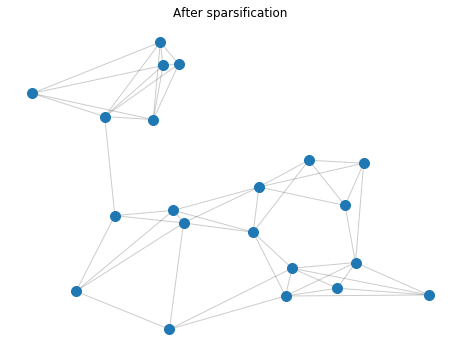

In [122]:
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(torch.cat((x['depot'][None, :], x['loc'][:, :2]), 0))}
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
plt.title('After sparsification')
plt.axis('off')
plt.show()

In [123]:
# G = nx.from_numpy_array(proba_adj)
# G.remove_edges_from(nx.selfloop_edges(G))
# pos = {i: coord.numpy() for i, coord in enumerate(torch.cat((x['depot'][None, :], x['loc'][:, :2]), 0))}
# plt.figure(figsize=(8, 6))
# nx.draw_networkx_nodes(G, pos=pos, node_size=100)
# nx.draw_networkx_edges(G, pos=pos, width=[(G[u][v]['weight']*2)**2 for u,v in G.edges])
# plt.title('Probabilistic graph')
# plt.axis('off')
# plt.show()

GNN model

In [124]:
def array_separator(arr):
  out = []
  out_temp = [0]
  for i in arr[1:]:
    if i == 0:
      if len(out_temp) != 1:
        out_temp.append(0)
        out.append(np.array(out_temp))
      out_temp = [0]
    else:
      out_temp.append(i)
  return np.array(out)

In [125]:
with torch.no_grad():
    model.decode_type = 'greedy'
    _, _, tour = model.forward(nodes, graph, car_num, return_pi=True)
tour = tour.cpu().numpy()[0]
# tour = np.append(tour, tour[0])

In [126]:
tour = torch.cat((torch.zeros(1), torch.tensor(tour))).type(torch.int64)
while len(tour) != 26:
    tour = torch.cat((torch.tensor(tour), torch.zeros(1))).type(torch.int64)

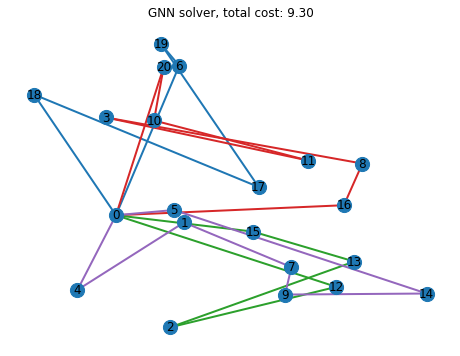

In [127]:
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1), edge_color = colors[n])
nx.draw_networkx_labels(G, pos)
dist_matrix_ = dist_matrix.copy()
dist_matrix_[(range(dist_matrix_.shape[0])), (range(dist_matrix_.shape[0]))] = 0
cost = dist_matrix_[tour[:-1], tour[1:]].sum()
plt.title(f'GNN solver, total cost: {cost:.2f}')
plt.axis('off')
plt.show()


In [128]:
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in tour[1:]:
      if i == 0:
          car+=1
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in tour[1:]:
      if i == 0:
          car+=1
      else:
          temp[car] += test_example['demand'][i-1]
temp

{0: tensor(1.), 1: tensor(0.9333), 2: tensor(0.9333), 3: tensor(0.8000), 4: 0}

OR-Tools

In [129]:
if cvrplib:
  from heurictics.op_tools import *
  from generator.distance_matrix import distance_function
  customer_count = 45+1

  distance = distance_function(test_df[['latitude', 'longitude']].values, is_coord = False)
  dist_matrix =pd.DataFrame(distance)
  dist_matrix.iloc[range(customer_count), range(customer_count)] = 0

  op_results = main(test_df, distance, cars = test_df['cars'].max(), cap = test_df['cap'].max())
  tour_sublist = np.array(list(op_results['paths'].values()))
  rtour = np.array([item for sublist in tour_sublist for item in sublist])
else:
  rtour = test_example['tour_nodes'].numpy()

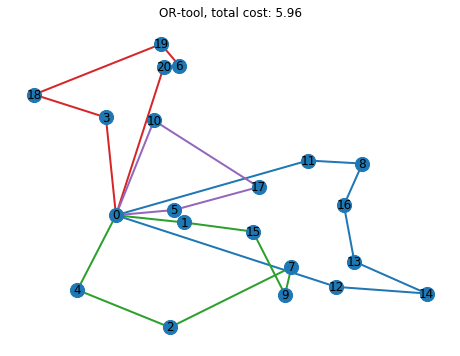

In [130]:
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(rtour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1), edge_color = colors[n])
nx.draw_networkx_labels(G,pos)
cost = dist_matrix_[rtour[:-1].astype(int), rtour[1:].astype(int)].sum()
plt.title(f'OR-tool, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

In [131]:
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in rtour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in rtour[1:].astype(int):
      if i == 0:
          car+=1
      else:
          temp[car] += test_example['demand'][i-1]
temp

{0: tensor(1.), 1: 0, 2: tensor(1.), 3: tensor(1.), 4: tensor(0.6667)}

Greedy solution

In [132]:
if not cvrplib:
  test_df_ = pd.DataFrame(torch.cat((test_example['depot'][None, : ], test_example['loc']), 0).numpy(), columns = ['latitude', 'longitude'])
  test_df_['demand'] = torch.cat((torch.zeros(1), test_example['demand']), 0).numpy()
  df_gr = test_df_.copy()
  df_gr['cap'] = 1
else:
  df_gr = test_df.copy()

In [133]:
from generator.distance_matrix import distance_function
customer_count = 21

distance = distance_function(df_gr[['latitude', 'longitude']].values, is_coord = False)
dist_matrix =pd.DataFrame(distance)
dist_matrix.iloc[range(customer_count), range(customer_count)] = np.inf

In [134]:
from heurictics.greedy import greedy_heurictics

greedy_results = greedy_heurictics(df_gr, dist_matrix, dim = customer_count, cap = df_gr['cap'].max(), k_nei = 3, iters = 100)

In [135]:
gr_tour = []
for p in greedy_results['paths'].values():
  for node in p: 
    gr_tour.append(node)

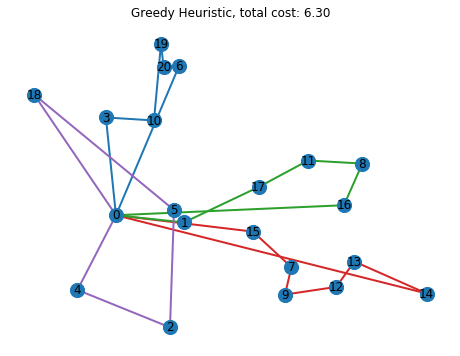

In [136]:
gr_tour = np.array(gr_tour)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(gr_tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1), edge_color = colors[n])
nx.draw_networkx_labels(G,pos)
cost = dist_matrix_[gr_tour[:-1].astype(int), gr_tour[1:].astype(int)].sum()
plt.title(f'Greedy Heuristic, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

Exact solution from CVRPLib (if exists)

NameError: name 'test_tour' is not defined

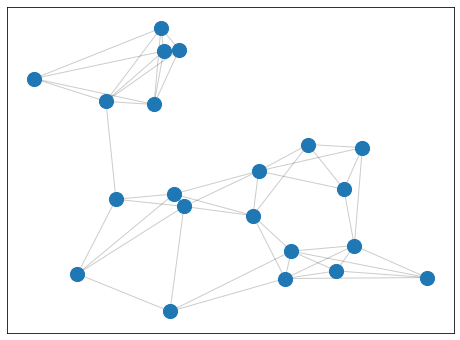

In [137]:
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(test_tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1), edge_color = colors[n])
nx.draw_networkx_labels(G, pos)
dist_matrix = squareform(pdist(x[:, :2].numpy()))
dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = np.inf
dist_matrix_ = dist_matrix.copy()
dist_matrix_[(range(dist_matrix_.shape[0])), (range(dist_matrix_.shape[0]))] = 0
cost = dist_matrix_[test_tour[:-1], test_tour[1:]].sum()
plt.title(f'CVRPLib, total cost: {cost:.2f}')
plt.axis('off')
plt.show()


In [ ]:
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in test_tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in test_tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_example['demand'][i-1]
temp

In [138]:
test_tour

NameError: name 'test_tour' is not defined